In [1]:
import tensorflow as tf

from unet_boarder_detection.tensorflow_example import upsample

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import numpy as np
import os
from PIL import Image
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
print(dataset)

print(info)

{'test': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>, 'train': <PrefetchDataset shapes: {file_name: (), image: (None, None, 3), label: (), segmentation_mask: (None, None, 1), species: ()}, types: {file_name: tf.string, image: tf.uint8, label: tf.int64, segmentation_mask: tf.uint8, species: tf.int64}>}
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3

In [13]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

def display(display_list):
  plt.figure(figsize=(15, 15))
  print(np.unique(display_list[0]))
  print(np.max(np.unique(display_list[0])))
  print(np.unique(display_list[1]))
  print(np.max(np.unique(display_list[1])))
  if len(display_list) > 2:
    print(np.unique(display_list[2]))
    print(np.max(np.unique(display_list[2])))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [14]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

print(len(train))

3680


In [15]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

[0.0000000e+00 9.5741427e-07 6.7018996e-06 ... 7.8131992e-01 7.8393364e-01
 7.9185051e-01]
0.7918505
[0.         0.00439453 0.03125    0.04833984 0.05419922 0.11474609
 0.12451172 0.14013672 0.15625    0.1772461  0.21875    0.22021484
 0.22705078 0.25830078 0.26904297 0.28125    0.28466797 0.28564453
 0.29052734 0.32958984 0.3383789  0.35595703 0.40625    0.53125
 0.59375    0.74072266 0.78125    0.81884766 0.8491211  0.96875
 1.         1.013916   1.0310059  1.0402832  1.0500488  1.0598145
 1.072998   1.0769043  1.078125   1.1008301  1.107666   1.1154785
 1.1459961  1.1491699  1.15625    1.1691895  1.171875   1.1901855
 1.1950684  1.203125   1.2043457  1.213623   1.2512207  1.265625
 1.277832   1.2834473  1.295166   1.2954102  1.3227539  1.328125
 1.34375    1.359375   1.3757324  1.4294434  1.4475098  1.4477539
 1.4506836  1.453125   1.46875    1.4836426  1.484375   1.4855957
 1.4870605  1.4897461  1.515625   1.53125    1.5327148  1.557373
 1.578125   1.5808105  1.5837402  1.640625   

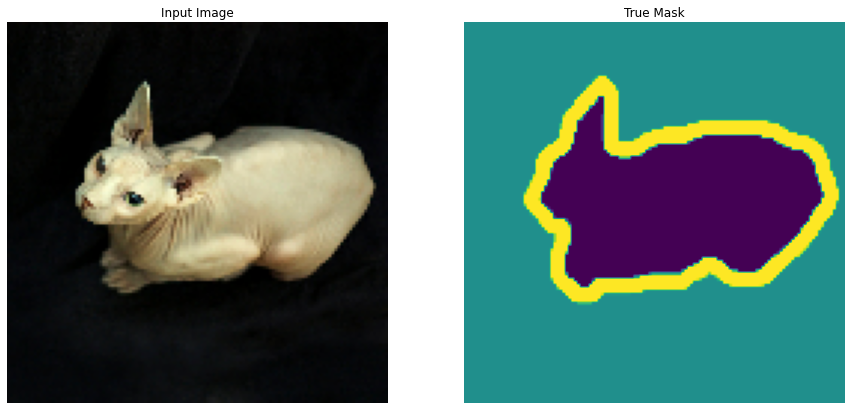

In [16]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])


In [17]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# 使用这些层的激活设置
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# 创建特征提取模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [18]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 在模型中降频取样
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 升频取样然后建立跳跃连接
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 这是模型的最后一层
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)



In [19]:
OUTPUT_CHANNELS = 3
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [21]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

[0.0000000e+00 9.5741427e-07 6.7018996e-06 ... 7.8131992e-01 7.8393364e-01
 7.9185051e-01]
0.7918505
[0.         0.00439453 0.03125    0.04833984 0.05419922 0.11474609
 0.12451172 0.14013672 0.15625    0.1772461  0.21875    0.22021484
 0.22705078 0.25830078 0.26904297 0.28125    0.28466797 0.28564453
 0.29052734 0.32958984 0.3383789  0.35595703 0.40625    0.53125
 0.59375    0.74072266 0.78125    0.81884766 0.8491211  0.96875
 1.         1.013916   1.0310059  1.0402832  1.0500488  1.0598145
 1.072998   1.0769043  1.078125   1.1008301  1.107666   1.1154785
 1.1459961  1.1491699  1.15625    1.1691895  1.171875   1.1901855
 1.1950684  1.203125   1.2043457  1.213623   1.2512207  1.265625
 1.277832   1.2834473  1.295166   1.2954102  1.3227539  1.328125
 1.34375    1.359375   1.3757324  1.4294434  1.4475098  1.4477539
 1.4506836  1.453125   1.46875    1.4836426  1.484375   1.4855957
 1.4870605  1.4897461  1.515625   1.53125    1.5327148  1.557373
 1.578125   1.5808105  1.5837402  1.640625   

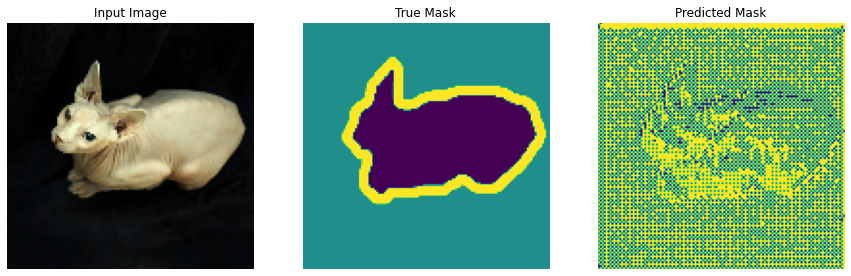

In [22]:
show_predictions()

0.7918505
[0.         0.00439453 0.03125    0.04833984 0.05419922 0.11474609
 0.12451172 0.14013672 0.15625    0.1772461  0.21875    0.22021484
 0.22705078 0.25830078 0.26904297 0.28125    0.28466797 0.28564453
 0.29052734 0.32958984 0.3383789  0.35595703 0.40625    0.53125
 0.59375    0.74072266 0.78125    0.81884766 0.8491211  0.96875
 1.         1.013916   1.0310059  1.0402832  1.0500488  1.0598145
 1.072998   1.0769043  1.078125   1.1008301  1.107666   1.1154785
 1.1459961  1.1491699  1.15625    1.1691895  1.171875   1.1901855
 1.1950684  1.203125   1.2043457  1.213623   1.2512207  1.265625
 1.277832   1.2834473  1.295166   1.2954102  1.3227539  1.328125
 1.34375    1.359375   1.3757324  1.4294434  1.4475098  1.4477539
 1.4506836  1.453125   1.46875    1.4836426  1.484375   1.4855957
 1.4870605  1.4897461  1.515625   1.53125    1.5327148  1.557373
 1.578125   1.5808105  1.5837402  1.640625   1.6506348  1.65625
 1.6831055  1.685791   1.6918945  1.7097168  1.7165527  1.71875
 1.74877

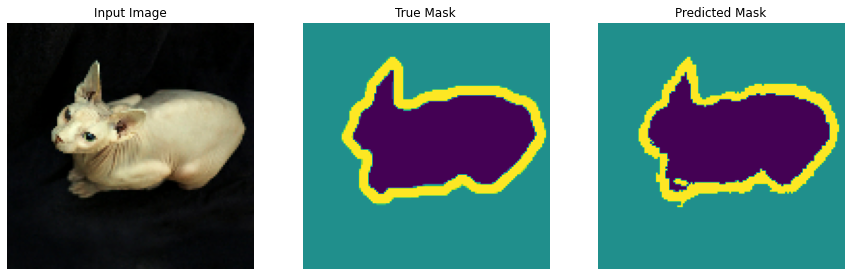


Sample Prediction after epoch 4

57/57 [==============================] - 6s 107ms/step - loss: 0.2608 - accuracy: 0.8909 - val_loss: 0.2809 - val_accuracy: 0.8877
Epoch 5/20
38/57 [===================>..........] - ETA: 1s - loss: 0.2510 - accuracy: 0.8943

KeyboardInterrupt: 

In [13]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])



In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

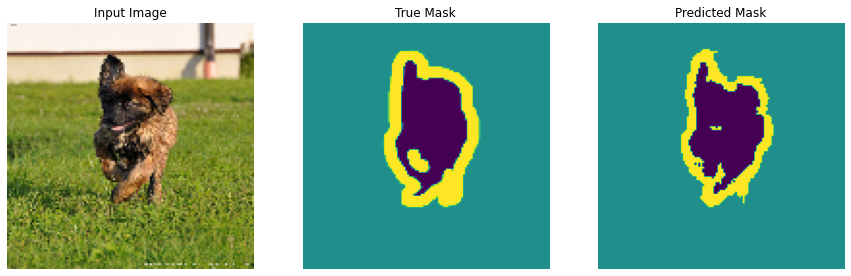

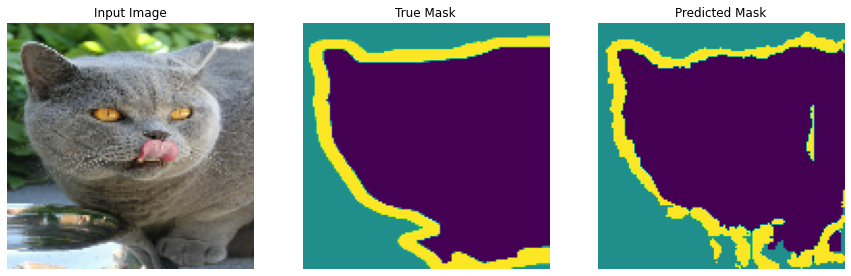

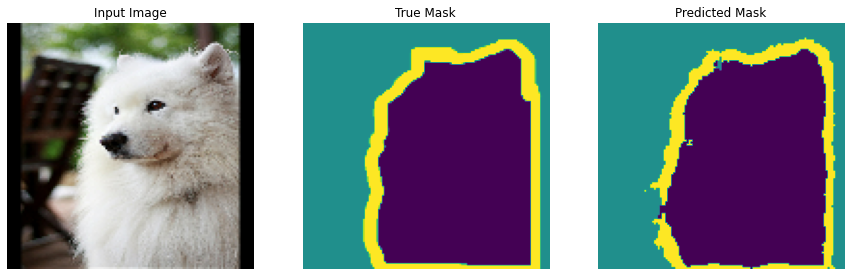

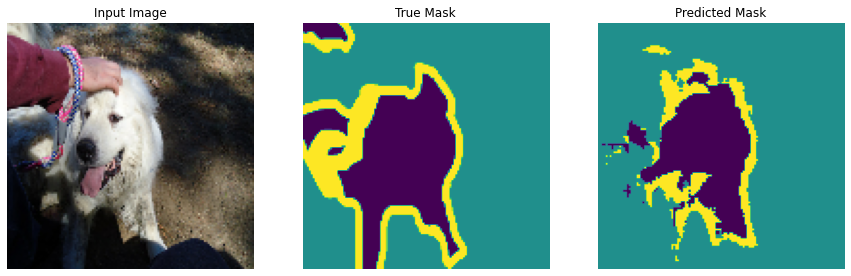

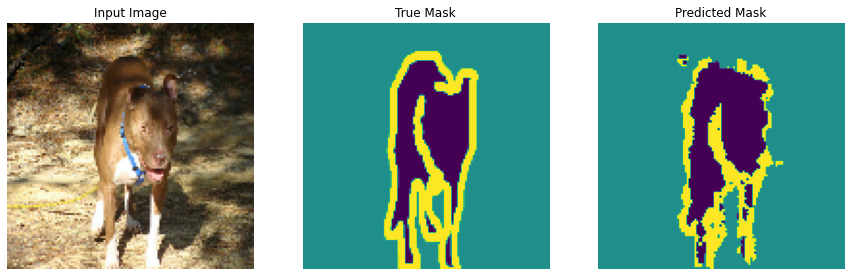

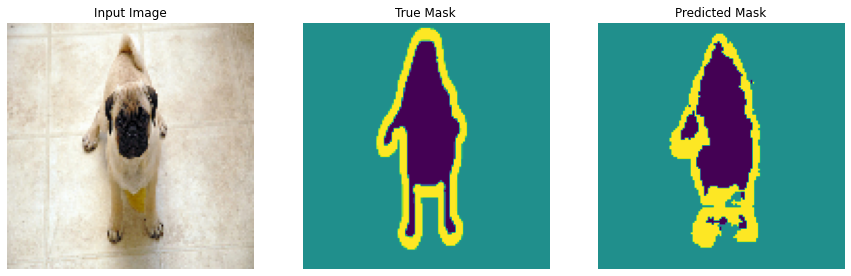

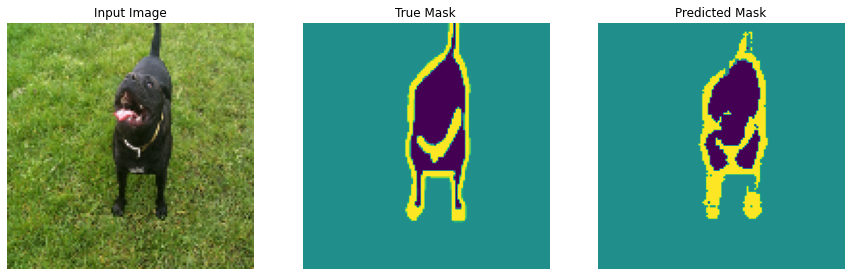

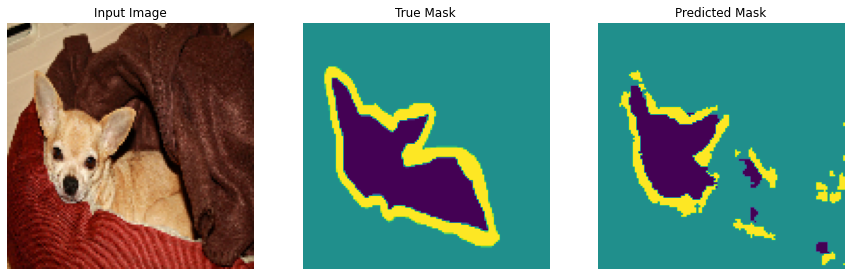

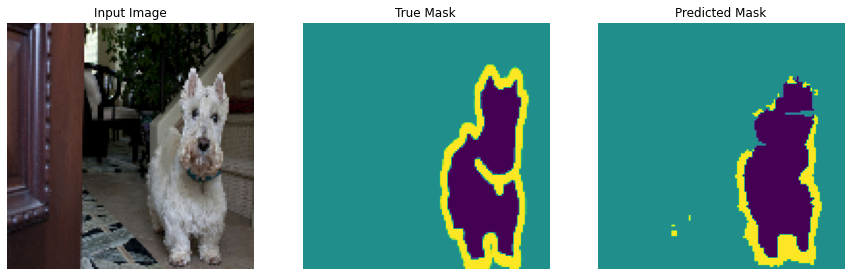

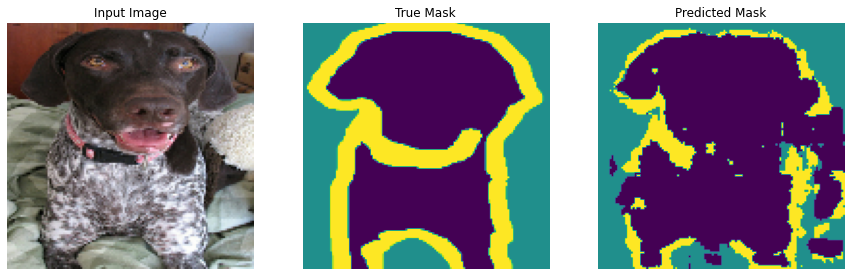

In [21]:
show_predictions(test_dataset, 10)
